# Adversarial Attack

In [0]:
import torch

In [0]:
import numpy as np
from PIL import Image
import json


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import torchvision.models as models
import torchvision.transforms as transforms

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets

import matplotlib.pyplot as plt

## 1. Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
model = models.resnet152(pretrained=True)
model.eval()
#print(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
torch.cuda.is_available()

True

In [0]:
idx = json.load(open('/content/drive/My Drive/imagenet_samples/imagenet_classes.json'))
idx2class = [idx[str(i)] for i in range(len(idx))]

In [0]:
transform = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
])

In [0]:
def image_pre(root, transform, custom_label) :
    
    data = dsets.ImageFolder(root = root, transform = transform)
    class2idx = {}
    
    for i, item in enumerate(idx2class) :
        class2idx[item] = i
    
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(data.classes[x]))
    new_data.classes = idx2class
    new_data.class2idx = class2idx

    return new_data

In [0]:
pre_data = image_pre(root = '/content/drive/My Drive/imagenet_samples/', transform = transform, custom_label=idx2class)
pre_loader = Data.DataLoader(pre_data, batch_size=1, shuffle=False)

In [0]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (3, 9))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

Clean Image


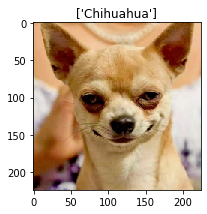

In [35]:
clean_iter = iter(pre_loader)
images, labels = clean_iter.next()

print("Clean Image")
imshow(torchvision.utils.make_grid(images, normalize=True), [pre_data.classes[i] for i in labels])

In [37]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

(Before Attack) Predicted Label


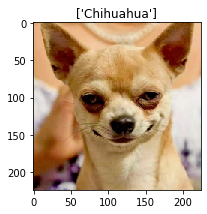

Confidence :99.72 %


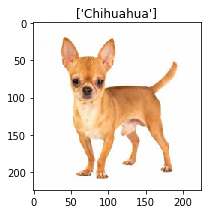

Confidence :99.88 %


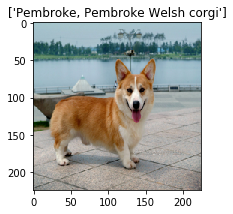

Confidence :98.26 %


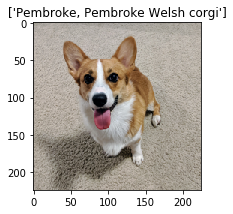

Confidence :97.63 %


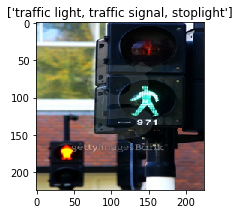

Confidence :47.62 %


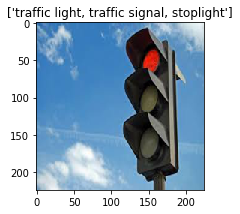

Confidence :95.77 %
Accuracy: 100.000000 %


In [38]:
print("(Before Attack) Predicted Label")

model.eval()

cnt = 0
total = 0

for images, labels in pre_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    _, pre = torch.max(outputs.data, 1)

    cnt += (pre == labels).sum()
    total += 1

    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [pre_data.classes[i] for i in pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
        
print('Accuracy: %f %%' % (100 * float(cnt) / total))

# 2. Attack method 

# 2.1 FGSM

In [0]:
def fgsm_attack(model, loss, images, labels, eps) :
    
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

(FGSM Attack) Predicted Label


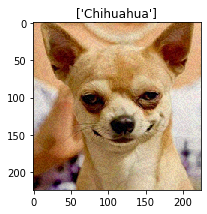

Confidence :64.33 %


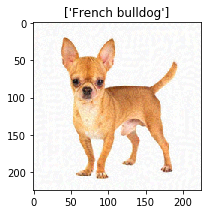

Confidence :98.77 %


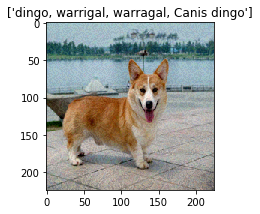

Confidence :66.22 %


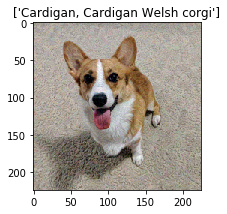

Confidence :15.52 %


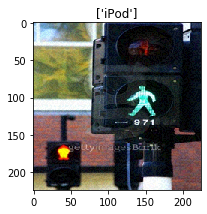

Confidence :76.08 %


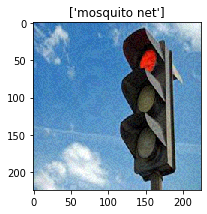

Confidence :44.21 %
Accuracy of test text: 16.666667 %


In [44]:
print("(FGSM Attack) Predicted Label")

loss = nn.CrossEntropyLoss()
model.eval()

cnt = 0
total = 0

for images, labels in pre_loader:
    
    images = fgsm_attack(model, loss , images, labels, 0.03).to(device)
    labels = labels.to(device)
    cnt += (pre == labels).sum()
    total += 1
    
    outputs = model(images)
    _, pre = torch.max(outputs.data, 1)
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [pre_data.classes[i] for i in pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
    
print('Accuracy of test text: %f %%' % (100 * float(cnt) / total))

# 2.2 PGD

In [0]:
def pgd_attack(model, images, labels, eps, alpha, iters) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    last_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - last_images, min=-eps, max=eps)
        images = torch.clamp(last_images + eta, min=0, max=1).detach_()
            
    return images

(PGD Attack) Predicted Label


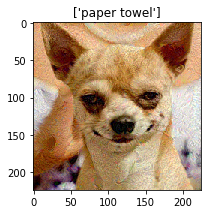

Confidence :100.00 %


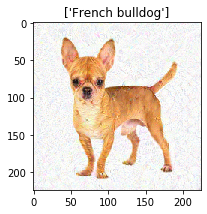

Confidence :100.00 %


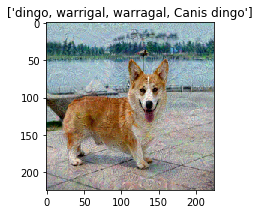

Confidence :100.00 %


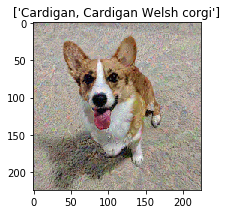

Confidence :100.00 %


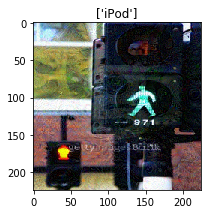

Confidence :100.00 %


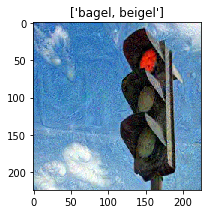

Confidence :100.00 %
Accuracy of test text: 0.000000 %


In [48]:
print("(PGD Attack) Predicted Label")

model.eval()

cnt = 0
total = 0

for images, labels in pre_loader:
    
    images = pgd_attack(model, images, labels, 0.3, 2/255, 40)
    labels = labels.to(device)
    
    outputs = model(images)
    _, pre = torch.max(outputs.data, 1)
    cnt += (pre == labels).sum()
    total += 1

    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [pre_data.classes[i] for i in pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
    
print('Accuracy of test text: %f %%' % (100 * float(cnt) / total))

# 2.3 Least Likely Attack

In [0]:
def ll_class_attack(model, loss, images, scale, eps, alpha, iters=0) :
    images = images.to(device)    
    outputs = model(images)
    _, labels = torch.min(outputs.data, 1)
    labels = labels.detach_()
        
    clamp_max = 224
    
    if iters == 0 :
        iters = int(min(eps + 4, 1.25*eps))
        
    if scale :
        eps = eps / 224
        clamp_max = clamp_max / 224
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        attack_images = images - alpha*images.grad.sign()

        x1 = torch.clamp(images - eps, min=0)
        x2 = (attack_images>=x1).float()*attack_images + (x1>attack_images).float()*x1
        x3 = (x2 > images+eps).float()*(images+eps) + (images+eps >= x2).float()*x2
        images = torch.clamp(x3, max=clamp_max).detach_()
    
    return images

(LL Attack) Predicted Label


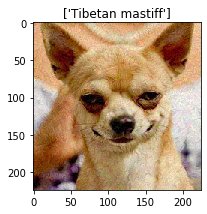

Confidence :96.22 %


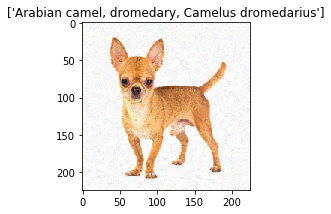

Confidence :18.43 %


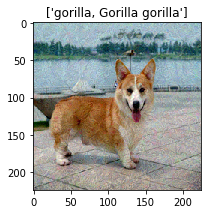

Confidence :96.16 %


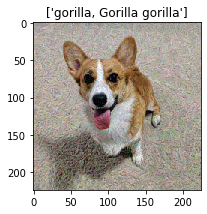

Confidence :51.62 %


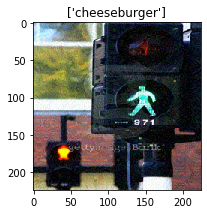

Confidence :98.74 %


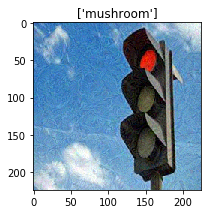

Confidence :31.20 %
Accuracy of test text: 0.000000 %


In [58]:
loss = nn.CrossEntropyLoss()
print("(LL Attack) Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in pre_loader:
    
    images = ll_class_attack(model, loss, images, 1, 4, 1).to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [pre_data.classes[i] for i in pre])
    print("Confidence :%.2f %%" % (nn.Softmax(dim=1)(outputs).max()*100).item())
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))